# SVM - Climate Sentiment Multiclass Classification By Elliptical Evenlope Denoise
## CS522 Project

Elliptical Envelope Denoise

### Dataset: 
https://www.kaggle.com/code/luiskalckstein/climate-sentiment-multiclass-classification

### Imports

In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from Common.DataCenter import data_center
from Common.preprocessor import normalize_preprocessing
from Common.UtilFuncs import print_evaluation, Evaluator
from Common.EllipticalEnvelopeMethod import EllipticalEnvelopeMethod

%matplotlib inline

Ev  = Evaluator()


### Text preprocessing

In [2]:
# parameter: original X of training set and test set
# return:  vectorised X of training set and test set
def text_preprocessing(X_train, X_test):
    # preprocessing with traditional NLP methodology
    X_train_normalized = normalize_preprocessing(X_train)
    X_test_normalized  = normalize_preprocessing(X_test)
    
    # vectorization
    # Convert texts to vectors by TFIDF
    vectorizer = TfidfVectorizer(ngram_range=(1,2))
    X_train_vec  = vectorizer.fit_transform(X_train_normalized)
    X_test_vec   = vectorizer.transform(X_test_normalized)
      
    return X_train_vec, X_test_vec

### One-hot encoding, convert the labels to vectors (4 x 1) each

In [3]:
# parameter: original y of training set, original y of test set
# return:  encoded y of training set and test set
def one_hot_encoding(y_train, y_test):
    mlb          = MultiLabelBinarizer()
    y_train_vec  = mlb.fit_transform(map(str, y_train))
    y_test_vec   = mlb.transform(map(str, y_test))
    return y_train_vec, y_test_vec


### Run SVM

In [4]:
# parameter:  vectorised X and encoded y of training set and test set
def run_SVM(X_train_vec, y_train_vec, X_test_vec, y_test_vec):
    # Run SVM - fit and predict
    SVM             = OneVsRestClassifier(LinearSVC(dual=False, class_weight='balanced'), n_jobs=-1)
    SVM.fit(X_train_vec, y_train_vec)
    y_pred          = SVM.predict(X_test_vec)
    return  y_pred


### Do an experiment

In [5]:
# Parameter: original X,y of training set and test set
def do_experiment(X_train, y_train, X_test, y_test):
    # Convert texts to vectors
    X_train_vec, X_test_vec = text_preprocessing(X_train, X_test)
    y_train_vec, y_test_vec = one_hot_encoding(y_train, y_test)

    # Run SVM and evaluate the results
    y_pred = run_SVM(X_train_vec, y_train_vec, X_test_vec, y_test_vec)

    # Print the evaluation
    print_evaluation(y_test_vec, y_pred, labels=[0,1,2,3])
    evaluateDF = Ev.evaluate(y_test_vec, y_pred)
    return evaluateDF

# do an experiment with denoise
# Parameter: original X,y of training set and test set
def do_experiment_denoise( trainDF, X_train, y_train, X_test, y_test, dimension):
    # Convert texts to vectors
    X_train_vec, X_test_vec = text_preprocessing(X_train, X_test)
    y_train_vec, y_test_vec = one_hot_encoding(y_train, y_test)

    # LearningWithNoisyLabels require the classifier has the entry predict_proba()
    # So, use CalibratedClassifierCV to wrap LinearSVC
    #SVM = CalibratedClassifierCV(LinearSVC(dual=False, class_weight='balanced'))
    SVM             = OneVsRestClassifier(LinearSVC(dual=False, class_weight='balanced'), n_jobs=-1)
    
    # clean noise in noisy data frame
    denoiseMethod = EllipticalEnvelopeMethod(dimension)
    cleanTrainDF, clean_X_train_vec, clean_y_train = denoiseMethod.CleanDFNoise(trainDF, X_train_vec, y_train )
    
    SVM.fit(clean_X_train_vec, clean_y_train)
    y_pred          = SVM.predict(X_test_vec)
    

    # Print the evaluation
    # One hot encoding for print_evaluation()
    _, y_pred = one_hot_encoding(y_train, y_pred)
    print_evaluation(y_test_vec, y_pred, labels=[0,1,2,3])

    evaluateDF = Ev.evaluate(y_test_vec, y_pred)
    return evaluateDF


### Main entry
**The settings of the noise sources.**

In [6]:
#Each entry: source type and (size, distribution)
noisy_set_sizes = {
    'mislabeled' : (8000, None),                   # max size: 15000
    'irrelevant' : (0, [0.25,0.25,0.25,0.25]),  # max size: 34259
    'translated' : (0, "reserve_labels"),       # max size: 5000
}


**Load the database and split it into training set, test set, noisy set, validation set**

In [7]:
# dc = data_center("twitter_sentiment_data_clean.csv", train_size = 20000, test_size = 4000, validation_size = 1000,
#                  noisy_size = noisy_set_sizes['mislabeled'][0] if 'mislabeled' in noisy_set_sizes.keys() else 0)

# Load the database and split it into training set, test set, noisy set, validation set
# Using noisy_set_sizes directly
dc = data_center("twitter_sentiment_data_clean.csv", train_size = 20000, test_size = 4000, validation_size = 1000,
                 noisy_size = noisy_set_sizes)


**Show the summary of the whole data**

In [8]:
dc.print_summary()


###################################### Data Summary #############################################
  Raw set (not cleaned) size: 40908
  Original set size: 40908
      sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
  Training set size: 20000
  Test set size: 4000
  Noisy set size: 8000
  Validation set size: 1000
      noise sources ('mislabeled', 'irrelevant', 'translated'): 100.0%, 0.0%, 0.0%
##################################################################################################


**To see the data features via a demo**

In [9]:
train_df = dc.get_train_with_noisy_df(1000,1000)
data_center.print_data(train_df.head(15))


,noise,noise_text,sentiment,origin(sentiment),tweetid(partial),message(partial)
37829,1,mislabeled,2,0,701899,@CHEXNewswatch check out https
34005,0,none,3,-1,605804,Obama to follow Al Gore into c
28105,1,mislabeled,3,2,956485,@Patriot4545 The next take wil
29275,0,none,2,-1,951653,umm ??? so itâ€™s basically su
29208,1,mislabeled,2,3,951154,Germany provides â‚¬22m to add
16847,1,mislabeled,2,3,856024,"Warmer summers, unpredictable"
11870,0,none,1,-1,840241,@bradcarlson_ not denying clim
1896,0,none,2,-1,796429,RT @emmaroller: A climate chan
120,0,none,1,-1,793214,@michellemalkin Trump wins ele
80,0,none,3,-1,793175,Satellites help scientists see


**Get the test set for evaluation.**

In [10]:
X_test, y_test = dc.get_test()


**Set distributions of training set.**

In [11]:
# distribution of training set
train_distribution = None


**Run experiments with different training sets, and use the same test set.**
**Please wait some minutes until the finish message appears.**

In [12]:
expriment_no    = 1
print("-------------- No noisy training sets ----------")
for size in [2000, 4000, 5000, 8000, 10000, 15000, 20000]:
    # Get a training set without noisy data
    X_train, y_train = dc.get_train(size, train_distribution)

    print("* Training set size: %d samples" % (len(y_train)))
    data_center.print_distribution("  Sentiments", y_train)

    # Do an experiment
    dfResult = do_experiment(X_train, y_train, X_test, y_test)
    Ev.add_evaluation(dfResult, size, 0, "-",
                              data_center.calc_distribution_str(y_train, 'sentiment', [0,1,2,3]),
                              "-", expriment_no
                              )
    expriment_no += 1

print("-------------- Noisy training sets -------------")
# The noise source distribution of the whole noisy data.
dc.print_noise_source_distribution("General noise source distribution")

# here is the hyperparameter for dimension reduction
svdDimension = (400, 800, 1500)
dimensionIndex = 0
lstSizes = [(4000, 1000), (8000, 2000), (15000, 5000)]

for size in lstSizes:
    # Get a noisy training set
    train_df         = dc.get_train_with_noisy_df(size[0], size[1], train_distribution)
    # 在这里重置index
    train_df.reset_index(drop=True, inplace=True)
    X_train, y_train = data_center.Xy(train_df)
    X_noisy          = train_df[train_df['noise'] != 0]

    print("* Noisy training set size: %d samples (%d original, %d noisy)" % (len(y_train), size[0], size[1]))
    data_center.print_distribution("  Sentiments", y_train)
    dc.print_noise_source_distribution("  Noise sources")

    # Do an experiment without de-noising
    print("  Before de-noising:")
    dfResult = do_experiment(X_train, y_train, X_test, y_test)
    Ev.add_evaluation(dfResult, size[0], size[1], "N",
                            data_center.calc_distribution_str(y_train, 'sentiment', [0,1,2,3]),
                            data_center.calc_distribution_str(X_noisy, 'noise', [1,2,3]),
                            expriment_no
                            )

    # Do an experiment with de-noising
    print("  After de-noising:")
    dfResult = do_experiment_denoise(train_df, X_train, y_train, X_test, y_test, svdDimension[dimensionIndex])
    dimensionIndex += 1
    Ev.add_evaluation(dfResult, size[0], size[1], "Y",
                            data_center.calc_distribution_str(y_train, 'sentiment', [0,1,2,3]),
                            data_center.calc_distribution_str(X_noisy, 'noise', [1,2,3]),
                            expriment_no + len(lstSizes)
                            )
    expriment_no += 1
    
print("-------------- Experiments are finished. -------------")    


-------------- No noisy training sets ----------
* Training set size: 2000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.349, 0.315, 0.711, 0.678]
    micro_f1: 0.626 , macro_f1: 0.513 , weighted_f1: 0.597, macro_precision: 0.592, macro_recall: 0.504
* Training set size: 4000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.442, 0.371, 0.741, 0.695]
    micro_f1: 0.657 , macro_f1: 0.562 , weighted_f1: 0.635, macro_precision: 0.623, macro_recall: 0.554
* Training set size: 5000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.466, 0.4, 0.746, 0.709]
    micro_f1: 0.668 , macro_f1: 0.580 , weighted_f1: 0.648, macro_precision: 0.636, macro_recall: 0.570
* Training set size: 8000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%
    f1 of classes: [0.521, 0.42, 0.758, 0.719]
    micro_f1: 

/Users/guopei/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-7104.680770063999262 > -7107.375577462430556). You may want to try with a higher value of support_fraction (current value: 0.799).
  warnings.warn(
/Users/guopei/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-7105.534290364912522 > -7109.137555958303892). You may want to try with a higher value of support_fraction (current value: 0.799).
  warnings.warn(
/Users/guopei/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-7106.300985615396712 > -7107.888521778115319). You may want to try with a higher value

    f1 of classes: [0.409, 0.372, 0.712, 0.639]
    micro_f1: 0.615 , macro_f1: 0.533 , weighted_f1: 0.605, macro_precision: 0.544, macro_recall: 0.537
* Noisy training set size: 10000 samples (8000 original, 2000 noisy)
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 13.5%, 20.0%, 43.4%, 23.1%
  Noise sources ('mislabeled', 'irrelevant', 'translated'): 100.0%, 0.0%, 0.0%
  Before de-noising:
    f1 of classes: [0.461, 0.383, 0.722, 0.674]
    micro_f1: 0.635 , macro_f1: 0.560 , weighted_f1: 0.625, macro_precision: 0.587, macro_recall: 0.551
  After de-noising:


/Users/guopei/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-24027.842505611359229 > -24039.988168156236497). You may want to try with a higher value of support_fraction (current value: 0.801).
  warnings.warn(
/Users/guopei/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-24031.092223584135354 > -24032.390918251836410). You may want to try with a higher value of support_fraction (current value: 0.801).
  warnings.warn(
/Users/guopei/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-24031.957142743045551 > -24036.906038766297570). You may want to try with a higher

    f1 of classes: [0.481, 0.386, 0.716, 0.646]
    micro_f1: 0.624 , macro_f1: 0.557 , weighted_f1: 0.618, macro_precision: 0.560, macro_recall: 0.566
* Noisy training set size: 20000 samples (15000 original, 5000 noisy)
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 14.7%, 20.3%, 41.9%, 23.2%
  Noise sources ('mislabeled', 'irrelevant', 'translated'): 100.0%, 0.0%, 0.0%
  Before de-noising:
    f1 of classes: [0.449, 0.403, 0.727, 0.675]
    micro_f1: 0.637 , macro_f1: 0.564 , weighted_f1: 0.630, macro_precision: 0.578, macro_recall: 0.566
  After de-noising:


/Users/guopei/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-54151.211110009848198 > -54156.312827465815644). You may want to try with a higher value of support_fraction (current value: 0.801).
  warnings.warn(
/Users/guopei/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-54155.307545766139810 > -54156.972568283927103). You may want to try with a higher value of support_fraction (current value: 0.801).
  warnings.warn(
/Users/guopei/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-54158.321452320575190 > -54161.279472791931767). You may want to try with a higher

    f1 of classes: [0.483, 0.411, 0.717, 0.659]
    micro_f1: 0.630 , macro_f1: 0.568 , weighted_f1: 0.626, macro_precision: 0.566, macro_recall: 0.581
-------------- Experiments are finished. -------------


**Show evaluations in a form (be sure the experiments have been finished)**

In [13]:
Ev.print()


,Origin,Noise,Denoised,Micro F1,Macro F1,Weighted F1,Macro Precision,Macro Recall,F1 of classes,Sentiments distribution,Noise sources distribution
Experiment,,,,,,,,,,,
1,2000,0,-,0.625651,0.513415,0.597445,0.591622,0.503592,"[0.349, 0.315, 0.711, 0.678]","[9.4%, 18.3%, 50.2%, 22.1%]",-
2,4000,0,-,0.657229,0.562267,0.634902,0.623003,0.553626,"[0.442, 0.371, 0.741, 0.695]","[9.4%, 18.3%, 50.2%, 22.1%]",-
3,5000,0,-,0.667753,0.580286,0.648046,0.636269,0.569531,"[0.466, 0.4, 0.746, 0.709]","[9.4%, 18.3%, 50.2%, 22.1%]",-
4,8000,0,-,0.682283,0.604498,0.665412,0.647677,0.597741,"[0.521, 0.42, 0.758, 0.719]","[9.4%, 18.3%, 50.2%, 22.1%]",-
5,10000,0,-,0.689442,0.614399,0.673934,0.645478,0.613033,"[0.534, 0.431, 0.765, 0.727]","[9.4%, 18.3%, 50.2%, 22.1%]",-
6,15000,0,-,0.701889,0.633075,0.687961,0.657390,0.636509,"[0.567, 0.452, 0.774, 0.74]","[9.4%, 18.3%, 50.2%, 22.1%]",-
7,20000,0,-,0.716268,0.654099,0.705114,0.668449,0.660337,"[0.599, 0.483, 0.788, 0.746]","[9.4%, 18.3%, 50.2%, 22.1%]",-
8,4000,1000,N,0.615143,0.521284,0.597829,0.574358,0.502180,"[0.389, 0.33, 0.708, 0.659]","[13.6%, 20.0%, 43.4%, 23.0%]","[100.0%, 0.0%, 0.0%]"
9,8000,2000,N,0.634855,0.559926,0.624668,0.587357,0.551234,"[0.461, 0.383, 0.722, 0.674]","[13.5%, 20.0%, 43.4%, 23.1%]","[100.0%, 0.0%, 0.0%]"


**Parameters for plotting.**

In [14]:
# Plot training set size vs. Macro F1
# x coordinate
xValue  = "x['Origin']+x['Noise']"
# also can try other numeric columns, like:
# xValue  = "x['Origin']"

# y coordinate
yValue  = "y['Macro F1']"
# also can try other numeric columns, like:
# yValue  = "y['Weighted F1']"
# yValue  = "y['Macro Precision']"

# Divide experiments into several groups, which will be plot as lines
lines = { # each item: name, filter
    'Original Data':      "df['Denoised']=='-'",
    'Noisy Data':       "df['Denoised']=='N'",
    'Denoised Data':    "df['Denoised']=='Y'",
}


**Plot the evaluations.**

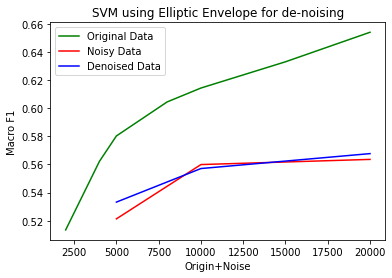

In [15]:
Ev.plot(xValue = xValue, yValue = yValue, lines = lines,
        title = 'SVM using Elliptic Envelope for de-noising')


In [17]:

Ev.evaluateDF.to_clipboard(excel=True)